In [2]:
%matplotlib inline
import requests
import json
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import zipfile
import os


Todo-List
- [X] Data exploration
- [X] SHP export and upload


In [3]:
def zipDir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            print(os.path.join(root, file))
            ziph.write(os.path.join(root, file))
            os.remove(os.path.join(root, file))

In [4]:
url='https://api.openaq.org/v1/latest'
payload = {
    'limit':10000,
    'has_geo':True
}
r = requests.get(url, params=payload)
r.status_code

200

In [5]:
from pandas.io.json import json_normalize
data = r.json()['results']
df = json_normalize(data, ['measurements'],[['coordinates', 'latitude'], ['coordinates', 'longitude'],'location', 'city', 'country'])

In [6]:
print(df.columns.values)
df.head(2)


['lastUpdated' 'parameter' 'sourceName' 'unit' 'value' 'country'
 'coordinates.longitude' 'coordinates.latitude' 'city' 'location']


,lastUpdated,parameter,sourceName,unit,value,country,coordinates.longitude,coordinates.latitude,city,location
0,2017-06-05T08:30:00.000Z,co,Agaar.mn,µg/m³,225.0,MN,106.921383,47.932906,Ulaanbaatar,100 ail
1,2017-06-05T08:30:00.000Z,no2,Agaar.mn,µg/m³,14.0,MN,106.921383,47.932906,Ulaanbaatar,100 ail


convert table into shapefile and export it :D 

In [7]:
geometry = [Point(xy) for xy in zip(df['coordinates.longitude'], df['coordinates.latitude'])]
df = df.drop(['coordinates.longitude', 'coordinates.latitude'], axis=1)
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(df, crs=crs, geometry=geometry)

In [8]:
geo_df.head(2)

,lastUpdated,parameter,sourceName,unit,value,country,city,location,geometry
0,2017-06-05T08:30:00.000Z,co,Agaar.mn,µg/m³,225.0,MN,Ulaanbaatar,100 ail,POINT (106.9213833 47.9329056)
1,2017-06-05T08:30:00.000Z,no2,Agaar.mn,µg/m³,14.0,MN,Ulaanbaatar,100 ail,POINT (106.9213833 47.9329056)


In [9]:
#geo_df.plot();

In [10]:
geo_df.parameter.unique()

array(['co', 'no2', 'o3', 'pm10', 'so2', 'pm25', 'bc'], dtype=object)

In [11]:
def export2shp(data, outdir, outname):
    current = os.getcwd()
    path= current+outdir
    os.mkdir(path)
    data.to_file(filename=(path+'/'+outname+'.shp'),driver='ESRI Shapefile')
    with zipfile.ZipFile(outname+'.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
                zipDir(path, zipf)
    os.rmdir(path)

In [12]:
outdir='/dst'
outname='test'
export2shp(geo_df, outdir, outname)

/home/jovyan/work/projects/wri-family/ResourceWatch/data_management/dst/test.cpg
/home/jovyan/work/projects/wri-family/ResourceWatch/data_management/dst/test.dbf
/home/jovyan/work/projects/wri-family/ResourceWatch/data_management/dst/test.prj
/home/jovyan/work/projects/wri-family/ResourceWatch/data_management/dst/test.shp
/home/jovyan/work/projects/wri-family/ResourceWatch/data_management/dst/test.shx


# Test with vega especification and adding maps

In [13]:
import folium
from vega import Vega

In [15]:
urlw='https://api.resourcewatch.org/widget/ea0ecd72-41f4-4ced-965c-c95204174048'
wr = requests.get(urlw)
wr.json()['data']['attributes']['widgetConfig']

{'axes': [{'properties': {'axis': {'stroke': {'value': '#9BA2AA'}},
    'labels': {'text': {'template': ''}}},
   'scale': 'x',
   'tickSize': 0,
   'type': 'x'},
  {'properties': {'axis': {'stroke': {'value': 'transparent'}},
    'labels': {'text': {'template': ''}}},
   'scale': 'y',
   'tickSize': 0,
   'type': 'y'}],
 'data': [{'format': {'property': 'rows', 'type': 'json'},
   'name': 'table',
   'url': "https://insights.carto.com/api/v2/sql?q=select total as y, 1 as group, to_number(to_char(year, 'yyyy'), '9999') as x FROM cait_2_0_country_ghg_emissions_filtered"}],
 'height': 150,
 'marks': [{'from': {'data': 'table',
    'transform': [{'groupby': ['group'], 'type': 'facet'}]},
   'marks': [{'properties': {'enter': {'stroke': {'field': 'group',
        'scale': 'group'},
       'strokeWidth': {'value': 2},
       'x': {'field': 'x', 'scale': 'x'},
       'y': {'field': 'y', 'scale': 'y'}}},
     'type': 'line'}],
   'type': 'group'}],
 'name': 'Line vizzualitation',
 'padding': 

In [16]:
conf = requests.get('https://raw.githubusercontent.com/resource-watch/resource-watch-app/master/src/utils/widgets/vega-theme-thumbnails.json').json()
spec = wr.json()['data']['attributes']['widgetConfig']

    
t = Vega(spec)
t.config = conf

In [17]:
t = []
path=''
def find_value(dic, val, path):
        for key, value in dic.items():
            if value == val:
                path = path +'[\''+ key + '\']'
                t.append(path)
            elif isinstance(dic[key], list):
                for i, data in enumerate(dic[key]):
                    if isinstance(data, dict):
                        symnpath = path +'[\''+ key +'\']['+ str(i)+']'
                        find_value(data, val, symnpath)
            elif isinstance(dic[key], dict):
                symnpath = path +'[\''+ key+'\']'
                find_value(dic[key], val, symnpath)

find_value(spec, 'colorRange1', path)
print(t[0])
fs = t[0]

['scales'][2]['range']


In [18]:
d = 'spec' + t[0]
print(d)
sdf = eval(d)
sdf

spec['scales'][2]['range']


'colorRange1'

In [19]:
exec("d=conf['range'][sdf]")

In [20]:
spec['scales'][2]['range']='category10'

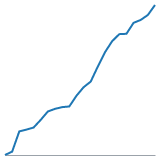

In [21]:
Vega(spec)

In [22]:
account = 'wri-rw'
urlCarto = 'https://'+account+'.carto.com/api/v1/map'
body = {
    "layers": [{
        "type": "cartodb",
        "options": {
            "sql": "select * from countries",
            "cartocss":"#layer {\n  polygon-fill: #374C70;\n  polygon-opacity: 0.9;\n  polygon-gamma: 0.5;\n  line-color: #FFF;\n  line-width: 1;\n  line-opacity: 0.5;\n  line-comp-op: soft-light;\n}",
            "cartocss_version": "2.1.1"
        }
    }]
}

In [23]:
r = requests.post(urlCarto, data=json.dumps(body), headers={'content-type': 'application/json; charset=UTF-8'})
tileUrl = 'https://'+account+'.carto.com/api/v1/map/' + r.json()['layergroupid'] + '/{z}/{x}/{y}.png32';

map_osm = folium.Map(location=[45.5236, 0.6750], zoom_start=3)
folium.TileLayer(
    tiles=tileUrl,
    attr='text',
    name='text',
    overlay=True
).add_to(map_osm)
map_osm